In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import datetime
import warnings
from jupyterthemes import jtplot

In [342]:
from ali.ali_sw import *

In [343]:
jtplot.style('default', grid=False)

In [6]:
def import_xps_spectrum(filename):
    dfin = pd.read_table(filename, sep='\s', skiprows=39, header=None, decimal='.', encoding='ascii')
    dfin.columns = ["energy", "counts"]
    # dfin['Energy [eV]'] = dfin['Energy [eV]'].map('{:.0f}'.format)

#     dfin.set_index("Energy [eV]", inplace=True)
    return dfin

In [228]:
file_bg = f'../xps_spectra/2019_09_26_Au_mica/20190927_Au_mica.xy'
df_bg = import_xps_spectrum(filename=file_bg)

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [229]:
file_fbi = '../xps_spectra/2019_09_27_FBI_Au_mica/20190927_FBI_Au_mica_overview.xy'
df_fbi = import_xps_spectrum(file_fbi)

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [74]:
def find_and_plot_peaks(df : pd.DataFrame, thres : float = 0.5, col : str = 'r'):
    leny = len(df.index)
    peaks = peakutils.indexes(df.counts.values, thres=thres)
    x_peaks = df.index[peaks]
    y_peaks = df.counts.values[peaks]
    plt.plot(x_peaks, y_peaks, col+'o', label='Peaks at thres = %.1f' %thres)
    
    return peaks

# Plot substrate and deposition spectra

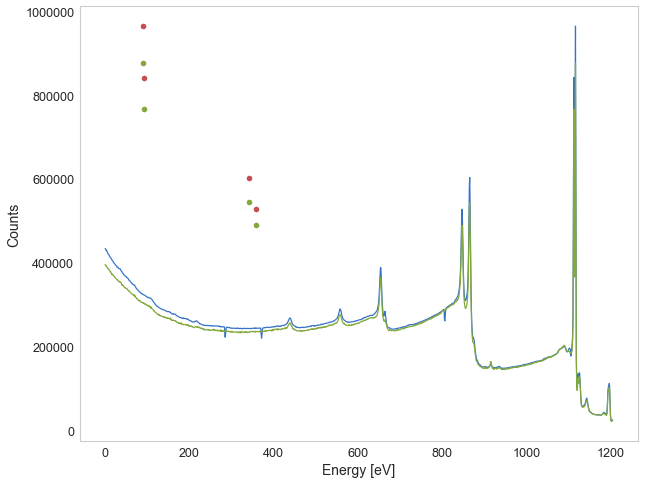

In [231]:
plt.figure(figsize=(10,8))
plt.plot(df_bg.counts, '-', label='Substrate spectrum: Au/Mica, sputtered and annealed')
plt.plot(df_fbi.counts, '-', label='FBI 2 pulses deposition 0.5 mM, 50 ms, 550 mbar')

plt.xlabel('Energy [eV]', fontsize=14)
plt.ylabel('Counts', fontsize=14)
# plt.title()

pBg = find_and_plot_peaks(df_bg, thres=0.5)
pFbi = find_and_plot_peaks(df_fbi, thres=0.5, col='g')

# plt.gca().invert_xaxis()
# plt.xlim(400,200)

## Compute normalization factor from Gold peaks

These may result from a slightly different position of the sample or the X-ray source

In [232]:
norm = df_bg.counts[pBg] / df_fbi.counts[pFbi]
normAv = np.average(norm)
normAv

1.0965601922478885

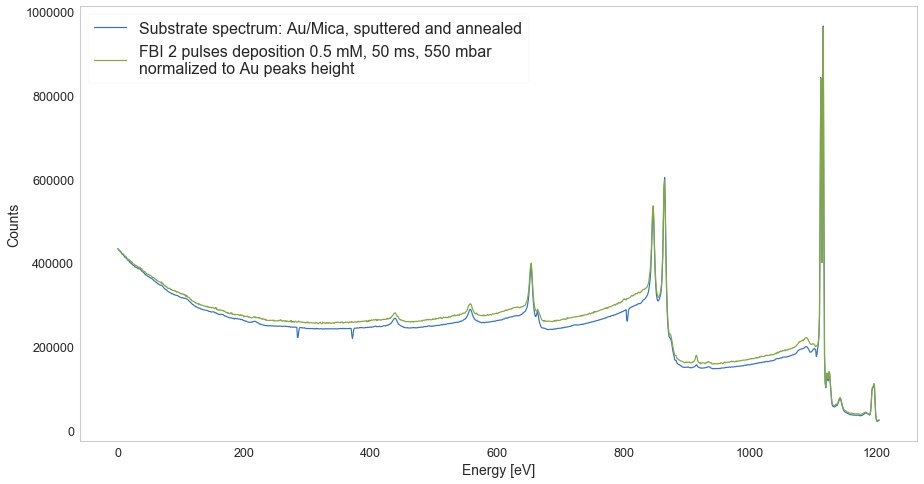

In [234]:
plt.figure(figsize=(15,8))
plt.plot(df_bg.counts, '-', label='Substrate spectrum: Au/Mica, sputtered and annealed')
plt.plot(df_fbi.counts*normAv, '-', label='FBI 2 pulses deposition 0.5 mM, 50 ms, 550 mbar \nnormalized to Au peaks height')

plt.xlabel('Energy [eV]', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.legend(fontsize = 16)
# plt.gca().invert_xaxis()

# Compare elementwise number of counts

##  Import fine-resolved element spectra

In [235]:
pathBg = f'../xps_spectra/2019_09_26_Au_mica/20190927_Au_mica'
path500nM = f'../xps_spectra/2019_09_27_FBI_Au_mica/20190927_FBI_Au_mica'

Cbg = import_xps_spectrum(pathBg+'_C.xy')
Csg = import_xps_spectrum(path500nM+'_C.xy')

Nsg = import_xps_spectrum(path500nM+'_N.xy')
Nbg = import_xps_spectrum(pathBg+'_N.xy')

Obg = import_xps_spectrum(pathBg+'_O.xy')
Osg = import_xps_spectrum(path500nM+'_O.xy')

Ba_bg = import_xps_spectrum(pathBg+'_Ba.xy')
Ba_sg = import_xps_spectrum(path500nM+'_Ba.xy')

# Didn't record bg fine resolved Cl spectra
Cl_sg = import_xps_spectrum(path500nM+'_Cl.xy')

Csg.counts *= normAv
Nsg.counts *= normAv
Osg.counts *= normAv
Ba_sg.counts *= normAv
Cl_sg.counts *= normAv

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [238]:
Cl_sg.index.values
Cl_bg = df_bg.counts[Cl_sg.index.values].dropna()
Cl_bg = pd.DataFrame(Cl_bg)
# Cl_bg = pd.DataFrame('Energy [eV]' = Cl_sg.index)

## Plot individual element spectra

In [110]:
def plot_xps_element_spectra(df_bg : pd.DataFrame, df_sg : pd.DataFrame, ax, lb):
    ax.plot(df_bg.counts, '-', label=lb+'_Substrate')
    ax.plot(df_sg.counts, '-', label=lb+'_Deposition')

    ax.set_xlabel('Energy [eV]', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.legend(fontsize = 12)
    ax.invert_xaxis()

In [274]:
def plot_xps_element_spectra(df_bg : pd.DataFrame, df_sg : pd.DataFrame, ax,
                            flag_smooth : bool = False, flag_area : bool = True):
    from scipy.ndimage.filters import gaussian_filter1d
    from matplotlib.patches import Patch

    if flag_smooth:
        y_bg = gaussian_filter1d(df_bg.counts, sigma = 2)
        y_sg = gaussian_filter1d(df_sg.counts, sigma = 2)
    else:
        y_bg = df_bg.counts
        y_sg = df_sg.counts
    
    ax.plot(df_bg.energy, y_bg, '-', label='Substrate')
    ax.plot(df_sg.energy, y_sg, '-', label='Deposition')

    ax.set_xlabel('Energy [eV]', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    lgd = ax.legend(fontsize = 12)
    
    if flag_area:
        step = df_bg.energy[0] - df_bg.energy[1]
        area = np.sum(df_sg.counts * step) / np.sum(df_bg.counts * step)
        handles, labels = lgd.axes.get_legend_handles_labels()
        
        handles.append(Patch(facecolor='orange', edgecolor='r'))
        
        labels.append('Area ratio: %.2f' %area)
        print('Area ratio: %.2f' %area)
        lgd._init_legend_box(handles, labels)

#         lgd.axes._init_legend_box(handles, labels)
    ax.legend(fontsize = 12)
    yl = ax.get_ylim()
    ax.set_ylim(0, 1.5*yl[1])
#     ax.set_yscale('log')
    ax.invert_xaxis()


Area ratio: 1.09
Area ratio: 1.09
Area ratio: 1.06
Area ratio: 1.05


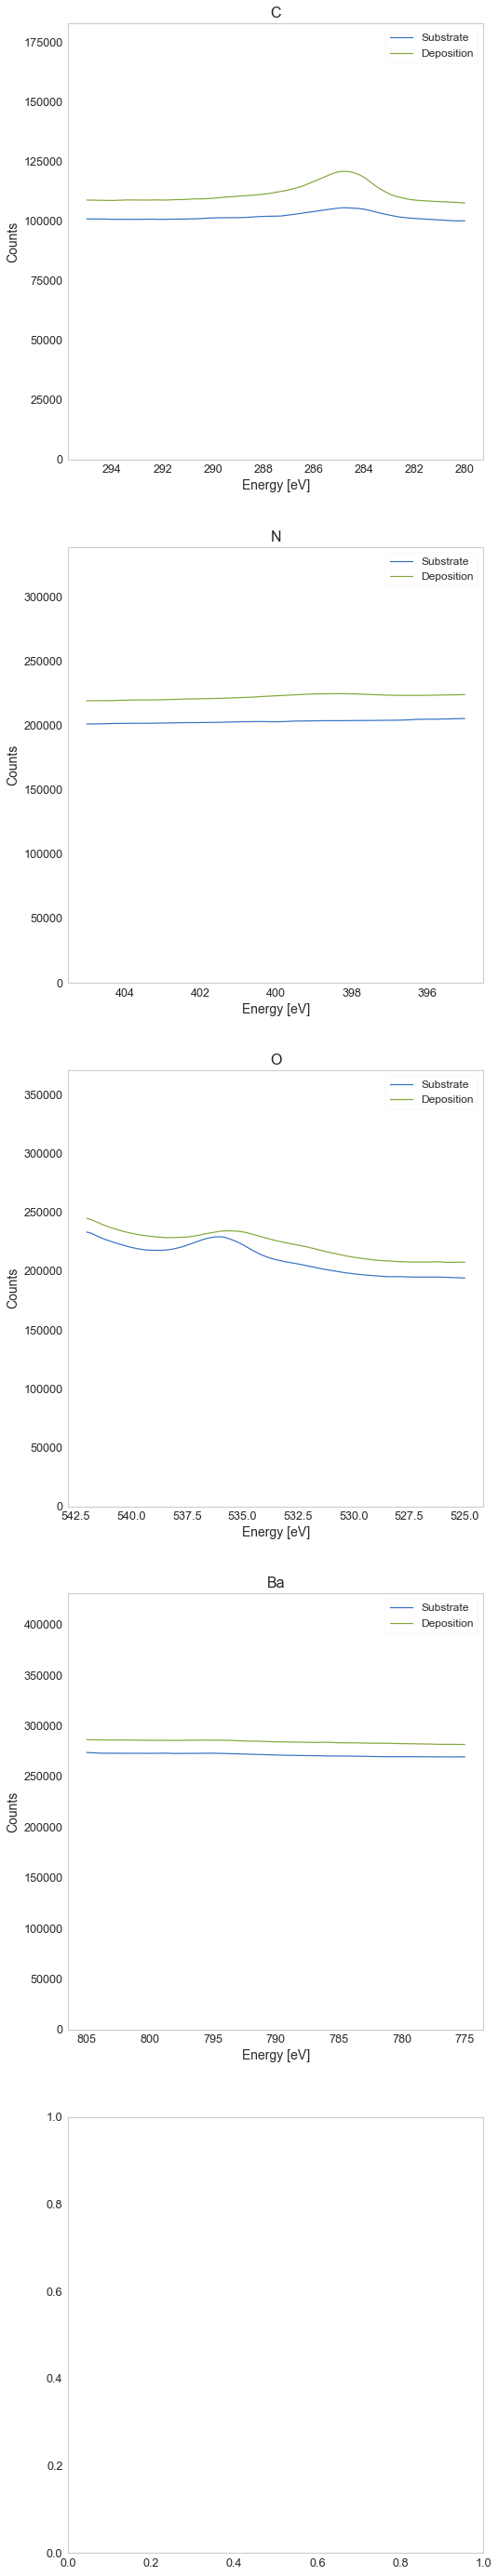

In [275]:
fig, ax = plt.subplots(5)
elem = ['C', 'N', 'O', 'Ba']#, 'Cl']
data_sg = [Csg, Nsg, Osg, Ba_sg]#, Cl_sg]
data_bg = [Cbg, Nbg, Obg, Ba_bg]#, Cl_bg]
for i, (d_sg, d_bg) in enumerate(zip(data_sg, data_bg)):
    plot_xps_element_spectra(d_bg, d_sg, ax[i], flag_smooth=True, flag_area=True)
    ax[i].set_title(elem[i], fontsize=16)
    
plt.gcf().set_figheight(10*len(ax))
plt.gcf().set_figwidth(8)

# Compare solvent only spectrum

In [7]:
file_bg2 = f'../xps_spectra/2019_09_30_Au_mica/20190930_Au_mica_clean.xy'
file_acn = f'../xps_spectra/2019_10_01_AcN_Au_mica/20191001_AcN_Au.xy'
file_acn_ali = f'../ali_data/Acetonitrile/500mbar/01102019_deposition_AcN_only_510mbar_50ms_5pulse'

### Import functions

In [314]:
class XPSImport():
    """Class to import XPS '.xy' data and metadata. 
    If more than one group needs to be retrieved, use import_xps_groups() function.
    Otherwise use the more efficient import_xps_df"""
    def __init__(self, path : str):
        self.path = path
        
    def find_groups(self):
        """Utility to find number of groups contained in file"""
        groupCount = 0
        with open(self.path) as infile:
            for i,line in enumerate(infile):
                if '# Group:' in line :
                    groupCount += 1
        return groupCount   
        
    def xps_file_metadata(self) -> tuple:
        """Retrieve position, name and number of lines of each spectrum in a .xy file"""
        
        skipRows0 = []
        nrows0 = []
        names = []

        with open(path) as infile:
            for i,line in enumerate(infile):
                if '# ColumnLabels: energy counts/s' in line:
                    skipRows0.append(i)
                if '# Region:' in line:
                    names.append(line[21:-1].replace(' ', '_'))
                if '# Values/Curve:' in line:
                    nrows0.append(int(line[21:-1]))
        return (skipRows0, nrows0, names)

    def import_xps_df(self) -> pd.DataFrame:
        """Join all spectra in an xps .xy file, each region contains a column with energy [in eV] and count values"""

        skipRows0, nrows0, names = self.xps_file_metadata()

        frames = []
        for j, re in enumerate(skipRows0):
            if j < len(skipRows0):
                frames.append(pd.read_table(path, sep='\s+', skiprows=re+2, nrows = nrows0[j], header=None, names=[names[j], 'counts'],
                                            decimal='.', encoding='ascii', engine='python'))

        df = pd.concat(frames, axis=1)

        index2 = np.array(['energy', 'counts'])
        mi = pd.MultiIndex.from_product([names, index2], names=['range', 'properties'])
        mi.to_frame()
        df.columns = mi

        return df
    
    def xps_groups_metadata(self) -> list:
        """Retrieve position, name and number of lines of each spectrum in a .xy file and arrange them by groups"""
        
        groupRows = []
        groupNames = []
        groupCount = -1
        skipRows0 = []
        nrows0 = []
        names = []

        with open(path) as infile:
            for i,line in enumerate(infile):
                if '# Group:' in line :
                    groupRows.append(i)
                    groupNames.append(line[21:-1].replace(' ', '_'))
                    groupCount += 1
                    skipRows0.append([])
                    nrows0.append([])
                    names.append([])

                if '# ColumnLabels: energy counts/s' in line:
                    skipRows0[ groupCount ].append( i )

                if '# Region:' in line:
                    names[groupCount ].append(line[21:-1].replace(' ', '_'))
                if '# Values/Curve:' in line:
                    nrows0[ groupCount ].append(int(line[21:-1]))
        return (groupRows, groupNames, skipRows0, nrows0, names)

    def import_xps_groups(self) -> list:
        """Arrange spectra df's by groups from file"""
        dfs = []
        skipRows0, nrows0, names, groupRows = self.xps_groups_metadata()

        for i, gr in enumerate(groupRows):
            frames = []
            for j, sk in enumerate(skipRows0[i]):
                if  (i == len(groupRows)-1 ) and (j == len(skipRows0[i]) -1 ) :
                    frames.append(pd.read_table(path, sep='\s+', skiprows=sk+2,  header=None, names=[names[i][j], 'counts'],
                                                    decimal='.', encoding='ascii', engine='python'))

            df = pd.concat(frames, axis=1)
            dfs.append(df)
            return dfs

In [313]:
XPSImport(path_au788_clean).import_xps_df()

range      overview_                                  C_1s             \
properties    energy    counts   energy    counts   energy     counts   
0             286.61  242260.0   286.61  211617.5  1191.61  40146.000   
1             287.61  242512.5   287.61  210520.0  1191.71  40210.000   
2             288.61  241025.0   288.61  210317.5  1191.81  40261.333   
3             289.61  241030.0   289.61  210267.5  1191.91  40439.333   
4             290.61  240207.5   290.61  209995.0  1192.01  40230.667   
5             291.61  239367.5   291.61  207715.0  1192.11  40186.000   
6             292.61  239315.0   292.61  207945.0  1192.21  40210.667   
7             293.61  238105.0   293.61  207120.0  1192.31  40367.333   
8             294.61  237107.5   294.61  206510.0  1192.41  40185.333   
9             295.61  236487.5   295.61  205757.5  1192.51  40182.667   
10            296.61  235097.5   296.61  206342.5  1192.61  40082.000   
11            297.61  234690.0   297.61  204122.5  1192.71  40120.000   
12            298.61  234810.0   298.61  203715.0  1192.81  40098.000   
13            299.61  234802.5   299.61  203800.0  1192.91  40255.333   
14            300.61  232422.5   300.61  203027.5  1193.01  40280.667   
15            301.61  232460.0   301.61  200115.0  1193.11  40372.000   
16            302.61  229532.5   302.61  201315.0  1193.21  40394.667   
17            303.61  229532.5   303.61  198835.0  1193.31  39956.667   
18            304.61  228975.0   304.61  197995.0  1193.41  40332.000   
19            305.61  229367.5   305.61  198555.0  1193.51  39949.333   
20            306.61  227745.0   306.61  198102.5  1193.61  40364.667   
21            307.61  227460.0   307.61  198402.5  1193.71  40112.000   
22            308.61  226847.5   308.61  197657.5  1193.81  39614.000   
23            309.61  225220.0   309.61  196680.0  1193.91  40068.667   
24            310.61  224672.5   310.61  195295.0  1194.01  40248.000   
25            311.61  225187.5   311.61  195090.0  1194.11  40268.667   
26            312.61  226065.0   312.61  194702.5  1194.21  40068.667   
27            313.61  224140.0   313.61  196085.0  1194.31  40306.000   
28            314.61  223745.0   314.61  193352.5  1194.41  40064.667   
29            315.61  223505.0   315.61  194522.5  1194.51  40162.667   
...              ...       ...      ...       ...      ...        ...   
1175         1461.61   34760.0  1461.61   25510.0      NaN        NaN   
1176         1462.61   34547.5  1462.61   25390.0      NaN        NaN   
1177         1463.61   35597.5  1463.61   25810.0      NaN        NaN   
1178         1464.61   36677.5  1464.61   26187.5      NaN        NaN   
1179         1465.61   36405.0  1465.61   27010.0      NaN        NaN   
1180         1466.61   37420.0  1466.61   27282.5      NaN        NaN   
1181         1467.61   38430.0  1467.61   28450.0      NaN        NaN   
1182         1468.61   39260.0  1468.61   28805.0      NaN        NaN   
1183         1469.61   40285.0  1469.61   29755.0      NaN        NaN   
1184         1470.61   40335.0  1470.61   30350.0      NaN        NaN   
1185         1471.61   39155.0  1471.61   28645.0      NaN        NaN   
1186         1472.61   38422.5  1472.61   28030.0      NaN        NaN   
1187         1473.61   38392.5  1473.61   27540.0      NaN        NaN   
1188         1474.61   37290.0  1474.61   27702.5      NaN        NaN   
1189         1475.61   35645.0  1475.61   26300.0      NaN        NaN   
1190         1476.61   37287.5  1476.61   26972.5      NaN        NaN   
1191         1477.61   44742.5  1477.61   32475.0      NaN        NaN   
1192         1478.61   65957.5  1478.61   47917.5      NaN        NaN   
1193         1479.61   92967.5  1479.61   67992.5      NaN        NaN   
1194         1480.61  100857.5  1480.61   73885.0      NaN        NaN   
1195         1481.61  101387.5  1481.61   73107.5      NaN        NaN   
1196         1482.61  110402.5  1482.61   79475.0      NaN

In [268]:
xps_file_metadata_v0(file_bg2)

([39, 1271, 1449, 1577, 1775, 1953],
 [1205, 151, 101, 171, 151, 101],
 ['overview_', 'C_1s', 'N_1s', 'O_1s', 'Ba_3d', 'Cl_2p'])

In [68]:
xps_file_metadata_v0(file_bg2)

([39, 1271, 1449, 1577, 1775, 1953],
 [1206, 152, 102, 172, 152],
 ['overview_', 'C_1s', 'N_1s', 'O_1s', 'Ba_3d', 'Cl_2p'])

In [272]:
dfBg2 = import_xps_df(file_bg2)
dfAcN = import_xps_df(file_acn)

### Plot ALI curve for AcN deposition

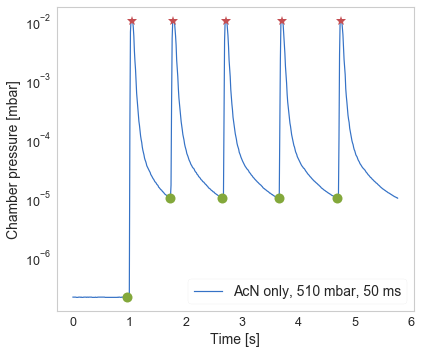

In [9]:
dfAcN_ali = load_raw_ali_df(file_acn_ali)
pe, tr = plot_pressure_curve(dfAcN_ali, tit='AcN only, 510 mbar, 50 ms', scale='s', )

### Normalize AcN spectrum

In [63]:
dfAcN

range          overview_             C_1s            N_1s             O_1s  \
properties        energy    counts energy   counts energy    counts energy   
0           1.200000e+03  258693.0  295.0  98833.7  405.0  167934.2  542.0   
1           1.199000e+03  257881.0  294.9  98618.4  404.9  168348.9  541.9   
2           1.198000e+03  257905.0  294.8  98580.1  404.8  168343.9  541.8   
3           1.197000e+03  256715.5  294.7  98563.4  404.7  168693.7  541.7   
4           1.196000e+03  256503.5  294.6  98718.4  404.6  168959.4  541.6   
5           1.195000e+03  255360.5  294.5  98838.9  404.5  169308.9  541.5   
6           1.194000e+03  254722.0  294.4  98682.9  404.4  169674.1  541.4   
7           1.193000e+03  253672.0  294.3  98841.0  404.3  169904.3  541.3   
8           1.192000e+03  252822.0  294.2  98968.7  404.2  170044.6  541.2   
9           1.191000e+03  252192.5  294.1  98818.2  404.1  170344.6  541.1   
10          1.190000e+03  249842.0  294.0  98853.3  404.0  170457.0  541.0   
11          1.189000e+03  248590.5  293.9  98804.6  403.9  171187.6  540.9   
12          1.188000e+03  247499.0  293.8  98941.2  403.8  171445.2  540.8   
13          1.187000e+03  246879.0  293.7  98935.8  403.7  171732.9  540.7   
14          1.186000e+03  246168.5  293.6  98821.1  403.6  171784.1  540.6   
15          1.185000e+03  244637.5  293.5  98889.9  403.5  172226.2  540.5   
16          1.184000e+03  243429.0  293.4  98745.6  403.4  172682.4  540.4   
17          1.183000e+03  243026.5  293.3  98791.4  403.3  173151.1  540.3   
18          1.182000e+03  242203.0  293.2  98815.8  403.2  173007.8  540.2   
19          1.181000e+03  241022.5  293.1  98879.0  403.1  173214.9  540.1   
20          1.180000e+03  240661.5  293.0  99054.9  403.0  173761.6  540.0   
21          1.179000e+03  240094.0  292.9  98724.5  402.9  173980.9  539.9   
22          1.178000e+03  238726.0  292.8  98887.1  402.8  174216.3  539.8   
23          1.177000e+03  238216.0  292.7  98736.9  402.7  174503.5  539.7   
24          1.176000e+03  238228.0  292.6  98694.9  402.6  174863.1  539.6   
25          1.175000e+03  237252.5  292.5  98976.8  402.5  174958.1  539.5   
26          1.174000e+03  236641.0  292.4  98742.0  402.4  175120.1  539.4   
27          1.173000e+03  236056.0  292.3  98850.5  402.3  175445.4  539.3   
28          1.172000e+03  234820.0  292.2  98998.8  402.2  175467.6  539.2   
29          1.171000e+03  235313.0  292.1  98852.6  402.1  175841.3  539.1   
...                  ...       ...    ...      ...    ...       ...    ...   
1175        2.500000e+01  106687.5    NaN      NaN    NaN       NaN    NaN   
1176        2.400000e+01  116155.0    NaN      NaN    NaN       NaN    NaN   
1177        2.300000e+01  113299.0    NaN      NaN    NaN       NaN    NaN   
1178        2.200000e+01   83058.5    NaN      NaN    NaN       NaN    NaN   
1179        2.100000e+01   50342.0    NaN      NaN    NaN       NaN    NaN   
1180        2.000000e+01   37731.0    NaN      NaN    NaN       NaN    NaN   
1181        1.900000e+01   36019.5    NaN      NaN    NaN       NaN    NaN   
1182        1.800000e+01   36309.0    NaN      NaN    NaN       NaN    NaN   
1183        1.700000e+01   36882.5    NaN      NaN    NaN       NaN    NaN   
1184        1.600000e+01   38130.5    NaN      NaN    NaN       NaN    NaN   
1185        1.500000e+01   38411.0    NaN      NaN    NaN       NaN    NaN   
1186        1.400000e+01   39023.0    NaN      NaN    NaN       NaN    NaN   
1187        1.300000e+01   39213.5    NaN      NaN    NaN       NaN    NaN   
1188        1.200000e+01   35950.0    NaN      NaN    NaN       NaN    NaN   
1189        1.100000e+01   32508.0    NaN      NaN    NaN       NaN    NaN   
1190        1.000000e+01   31533.5    NaN      NaN    NaN       NaN    NaN   
1191        9.000000e+00   34909.0    NaN      NaN    NaN       NaN    NaN   
1192        8.000000e+00   47957.0    NaN      NaN    NaN       NaN    NaN   
1193        7.000000e+

In [90]:
def find_and_plot_peaks(df : pd.DataFrame, thres : float = 0.5, col : str = 'r'):
    leny = len(df.index)
    peaks =  peakutils.indexes(df.counts.values, thres=thres)
    x_peaks = leny - df.index[peaks]
    y_peaks = df.counts.values[peaks]
    plt.plot(x_peaks, y_peaks, col+'o', label='Peaks at thres = %.1f' %thres)
    
    return peaks

In [100]:

def scale_and_plot_spectra(df : pd.DataFrame, dfRef : pd.DataFrame, lb : tuple, thres: float = 0.5) -> float:
    """Plot two spectra and compute average count ratio between main peaks for scaling
    Input:
    -----------------
    df: pd.DataFrame
        DataFrame containing the spectrum region to scale UP
    dfRef: pd.DataFrame
        Reference DataFrame to compare to
    lb : tuple
        Labels for legend
    thres : float
        Peak-finding count threshold, shouldn't be too low
    Output:
    ------------------
    normAv : float
        Scale factor computed as the average ratio between peak heights. Should be > 1,
        otherwise the reference spectrum has weaker intensity than the one intended to scale up
        """
    plt.figure(figsize=(10,8))
    plt.plot(df.energy, df.counts, '-b', label=lb[0])
    plt.plot(dfRef.energy, dfRef.counts, '-r', label=lb[1])

    plt.xlabel('Energy [eV]', fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.legend()
    plt.gca().invert_xaxis()

    pe = find_and_plot_peaks(df, thres=0.5, col='b')
    pRef = find_and_plot_peaks(dfRef, thres=0.5, col='r')

    norm = dfRef.counts[pRef] / df.counts[pe]
    normAv = np.average(norm)
    return normAv

0.9366368432580539

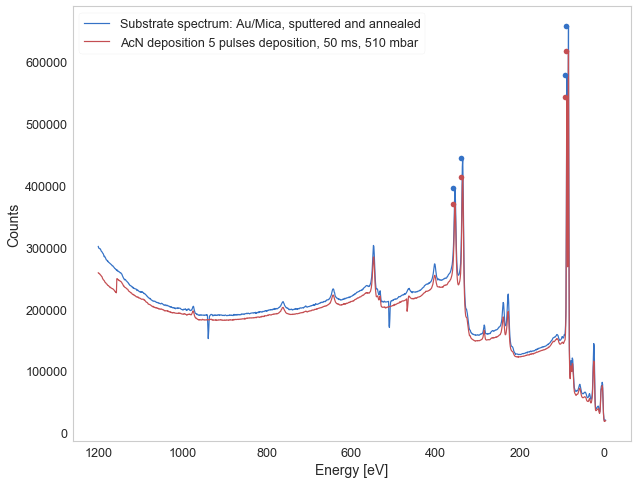

In [101]:
lb = ('Substrate spectrum: Au/Mica, sputtered and annealed', 'AcN deposition 5 pulses deposition, 50 ms, 510 mbar')
scale_and_plot_spectra(dfBg2.overview_, dfAcN.overview_, lb = lb)

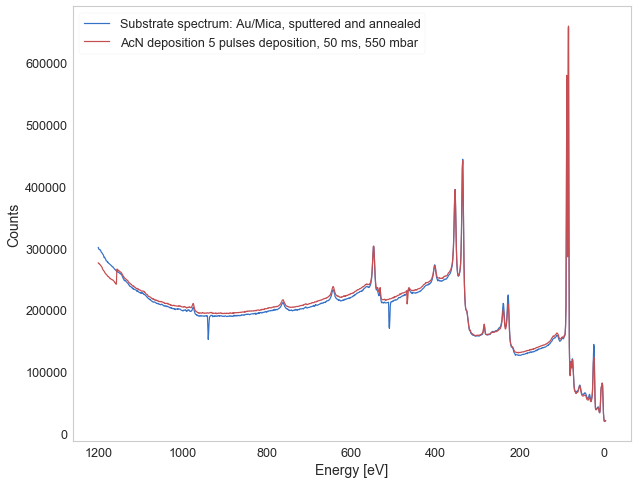

In [95]:
plt.figure(figsize=(10,8))
plt.plot(dfBg2.overview_.energy, dfBg2.overview_.counts, '-b', label='Substrate spectrum: Au/Mica, sputtered and annealed')
plt.plot(dfAcN.overview_.energy, dfAcN.overview_.counts*normAv, '-r', label='AcN deposition 5 pulses deposition, 50 ms, 550 mbar')

plt.xlabel('Energy [eV]', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.legend()
plt.gca().invert_xaxis()
# plt.xlim(400,200)

In [114]:
_, _, names = xps_file_metadata(file_bg2)
names

['overview_', 'C_1s', 'N_1s', 'O_1s', 'Ba_3d', 'Cl_2p']

In [167]:
dfBg2 = import_xps_df(file_bg2)
dfAcN = import_xps_df(file_acn)

In [168]:
for n in names:
    dfAcN[n, 'counts'] *= normAv

## Compare individual regions 

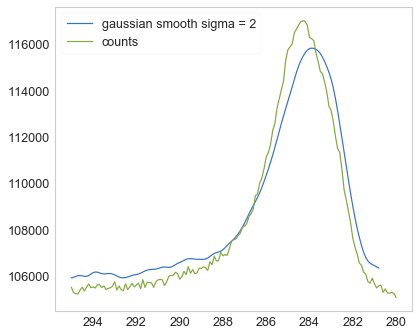

In [186]:
from scipy.ndimage.filters import gaussian_filter1d
# plt.plot(dfBg2.C_1s.energy, dfBg2.C_1s.counts)
ysm = gaussian_filter1d(dfBg2.C_1s.counts, sigma = 2)
plt.plot(dfBg2.C_1s.energy, ysm, label='gaussian smooth sigma = 2')


plt.plot(dfAcN.C_1s.energy, dfAcN.C_1s.counts)
plt.legend()
plt.gca().invert_xaxis()

In [181]:
step = dfBg2.C_1s.energy[0] - dfBg2.C_1s.energy[1]
np.sum(dfBg2.C_1s.counts * step) / np.sum(dfAcN.C_1s.counts * step)

1.0026659935657107

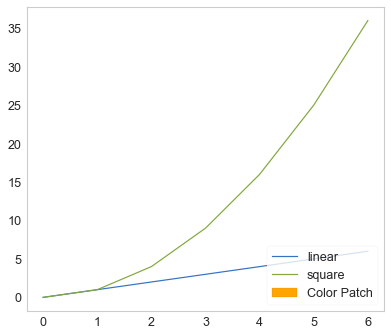

In [195]:
fig, ax = plt.subplots()
ax.plot([0,1,2,3,4,5,6], label='linear')
ax.plot([0,1,4,9,16,25,36], label='square')
lgd = ax.legend(loc='lower right')

def add_patch(legend):
    from matplotlib.patches import Patch
    ax = legend.axes

    handles, labels = ax.get_legend_handles_labels()
    handles.append(Patch(facecolor='orange', edgecolor='r'))
    labels.append("Color Patch")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())


add_patch(lgd)


In [213]:
def plot_xps_element_spectra(df_bg : pd.DataFrame, df_sg : pd.DataFrame, ax,
                            flag_smooth : bool = False, flag_area : bool = True):
    from scipy.ndimage.filters import gaussian_filter1d
    if flag_smooth:
        y_bg = gaussian_filter1d(df_bg.counts, sigma = 2)
        y_sg = gaussian_filter1d(df_sg.counts, sigma = 2)
    else:
        y_bg = df_bg.counts
        y_sg = df_sg.counts
    
    ax.plot(df_bg.energy, y_bg, '-', label='Substrate')
    ax.plot(df_sg.energy, y_sg, '-', label='Deposition')

    ax.set_xlabel('Energy [eV]', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    lgd = ax.legend(fontsize = 12)
    
    if flag_area:
        step = df_bg.energy[0] - df_bg.energy[1]
        area = np.sum(df_bg.counts * step) / np.sum(df_sg.counts * step)
        handles, labels = lgd.axes.get_legend_handles_labels()
#         handles.append()
        labels.append('Area ratio: %.2f' %area)
        print('Area ratio: %.2f' %area)
#         lgd.axes._init_legend_box(handles, labels)
    ax.legend(fontsize = 12)
    ax.invert_xaxis()

Area ratio: 1.00
Area ratio: 1.03
Area ratio: 1.02
Area ratio: 1.04
Area ratio: 1.04


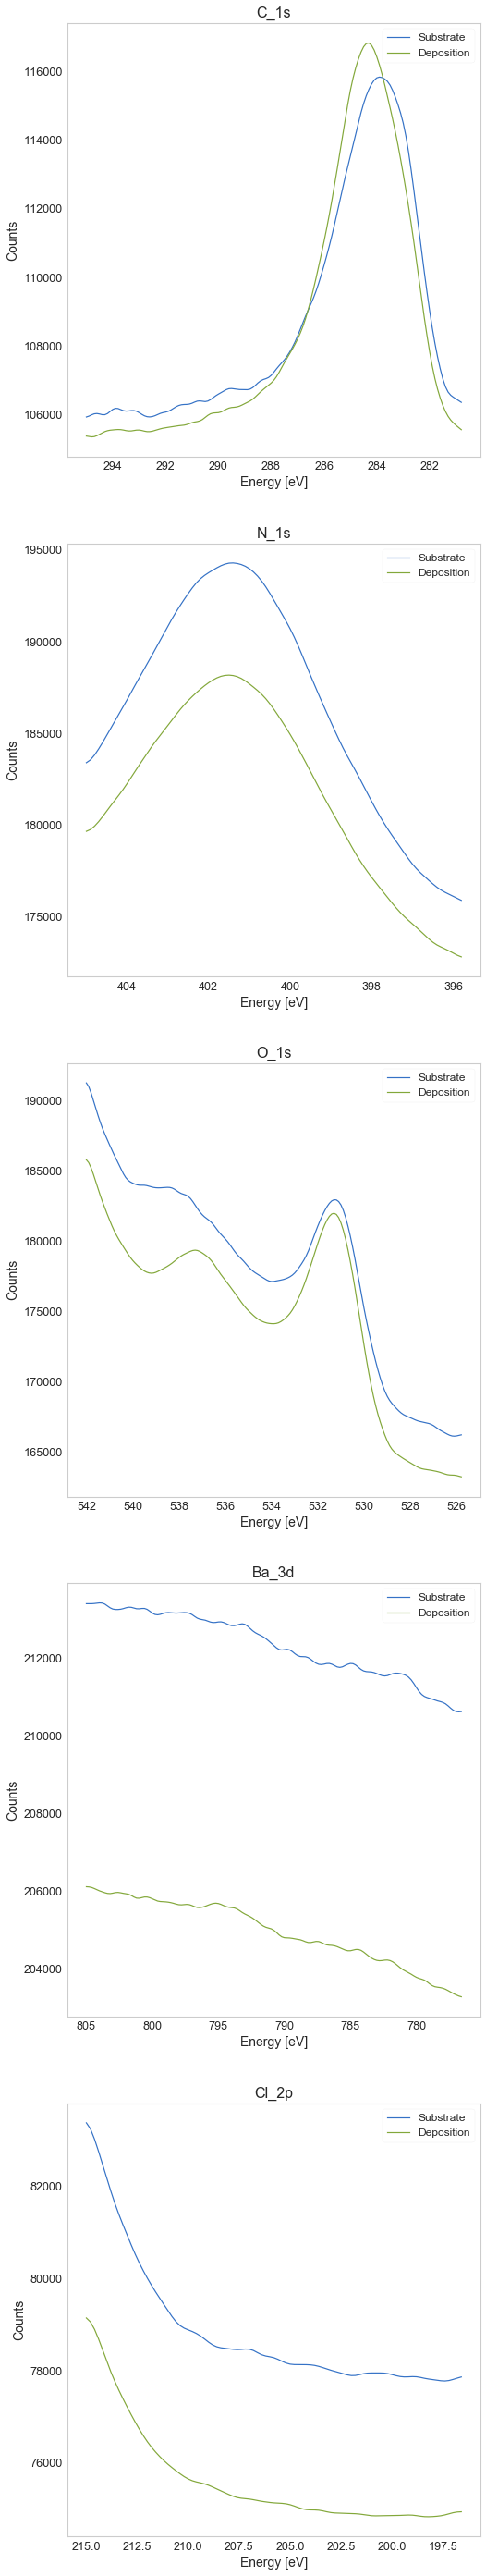

In [214]:
fig, ax = plt.subplots(5)

for i,n in enumerate(names[1:]):
    plot_xps_element_spectra(dfBg2[n], dfAcN[n], ax[i], flag_smooth=True, flag_area=True)
    ax[i].set_title(n, fontsize=16)
    
plt.gcf().set_figheight(10*len(ax))
plt.gcf().set_figwidth(8)

# FBI depositions 

In [28]:
path_au788_clean = '/Users/pabloherrero/sabat/xps_spectra/2019_10_16_Au_crystal_FBI/20191016_Au(788)_clean.xy'
path_fbi_40pulse_au788 = '/Users/pabloherrero/sabat/xps_spectra/2019_10_16_Au_crystal_FBI/20191016_FBI_FBI_Ba_1uM_40pulse_50ms_Au(788).xy'

In [276]:
xps_groups_metadata(path_au788_clean)

([15, 1250, 2485],
 ['FirstMeasurements',
  'SecondMeasurements',
  'ThirdMeasurementAfterSputter1500eV'],
 [[42], [1277], [2512, 2691, 2820, 3019, 3198]],
 [[1205], [1205], [151, 101, 171, 151, 101]],
 [['overview_'], ['overview_'], ['C_1s', 'N_1s', 'O_1s', 'Ba_3d', 'Cl_2p']])

In [263]:
xps_file_metadata(path_fbi_40pulse_au788)

([42, 1275, 1454, 1583, 1782, 1961],
 [1205, 151, 101, 171, 151, 101],
 ['overview_', 'C_1s', 'N_1s', 'O_1s', 'Ba_3d', 'Cl_2p'],
 [])

In [317]:
df_clean = XPSImport(path_au788_clean).import_xps_df()
df_clean

range      overview_                                  C_1s             \
properties    energy    counts   energy    counts   energy     counts   
0             286.61  242260.0   286.61  211617.5  1191.61  40146.000   
1             287.61  242512.5   287.61  210520.0  1191.71  40210.000   
2             288.61  241025.0   288.61  210317.5  1191.81  40261.333   
3             289.61  241030.0   289.61  210267.5  1191.91  40439.333   
4             290.61  240207.5   290.61  209995.0  1192.01  40230.667   
5             291.61  239367.5   291.61  207715.0  1192.11  40186.000   
6             292.61  239315.0   292.61  207945.0  1192.21  40210.667   
7             293.61  238105.0   293.61  207120.0  1192.31  40367.333   
8             294.61  237107.5   294.61  206510.0  1192.41  40185.333   
9             295.61  236487.5   295.61  205757.5  1192.51  40182.667   
10            296.61  235097.5   296.61  206342.5  1192.61  40082.000   
11            297.61  234690.0   297.61  204122.5  1192.71  40120.000   
12            298.61  234810.0   298.61  203715.0  1192.81  40098.000   
13            299.61  234802.5   299.61  203800.0  1192.91  40255.333   
14            300.61  232422.5   300.61  203027.5  1193.01  40280.667   
15            301.61  232460.0   301.61  200115.0  1193.11  40372.000   
16            302.61  229532.5   302.61  201315.0  1193.21  40394.667   
17            303.61  229532.5   303.61  198835.0  1193.31  39956.667   
18            304.61  228975.0   304.61  197995.0  1193.41  40332.000   
19            305.61  229367.5   305.61  198555.0  1193.51  39949.333   
20            306.61  227745.0   306.61  198102.5  1193.61  40364.667   
21            307.61  227460.0   307.61  198402.5  1193.71  40112.000   
22            308.61  226847.5   308.61  197657.5  1193.81  39614.000   
23            309.61  225220.0   309.61  196680.0  1193.91  40068.667   
24            310.61  224672.5   310.61  195295.0  1194.01  40248.000   
25            311.61  225187.5   311.61  195090.0  1194.11  40268.667   
26            312.61  226065.0   312.61  194702.5  1194.21  40068.667   
27            313.61  224140.0   313.61  196085.0  1194.31  40306.000   
28            314.61  223745.0   314.61  193352.5  1194.41  40064.667   
29            315.61  223505.0   315.61  194522.5  1194.51  40162.667   
...              ...       ...      ...       ...      ...        ...   
1175         1461.61   34760.0  1461.61   25510.0      NaN        NaN   
1176         1462.61   34547.5  1462.61   25390.0      NaN        NaN   
1177         1463.61   35597.5  1463.61   25810.0      NaN        NaN   
1178         1464.61   36677.5  1464.61   26187.5      NaN        NaN   
1179         1465.61   36405.0  1465.61   27010.0      NaN        NaN   
1180         1466.61   37420.0  1466.61   27282.5      NaN        NaN   
1181         1467.61   38430.0  1467.61   28450.0      NaN        NaN   
1182         1468.61   39260.0  1468.61   28805.0      NaN        NaN   
1183         1469.61   40285.0  1469.61   29755.0      NaN        NaN   
1184         1470.61   40335.0  1470.61   30350.0      NaN        NaN   
1185         1471.61   39155.0  1471.61   28645.0      NaN        NaN   
1186         1472.61   38422.5  1472.61   28030.0      NaN        NaN   
1187         1473.61   38392.5  1473.61   27540.0      NaN        NaN   
1188         1474.61   37290.0  1474.61   27702.5      NaN        NaN   
1189         1475.61   35645.0  1475.61   26300.0      NaN        NaN   
1190         1476.61   37287.5  1476.61   26972.5      NaN        NaN   
1191         1477.61   44742.5  1477.61   32475.0      NaN        NaN   
1192         1478.61   65957.5  1478.61   47917.5      NaN        NaN   
1193         1479.61   92967.5  1479.61   67992.5      NaN        NaN   
1194         1480.61  100857.5  1480.61   73885.0      NaN        NaN   
1195         1481.61  101387.5  1481.61   73107.5      NaN        NaN   
1196         1482.61  110402.5  1482.61   79475.0      NaN

# Summary

#####  We have no clear signal of Ba nor Cl so the Barium perchlorate doesn't clearly survive

- We do have some clear excess in the C and N peaks, probably from the acetonitrile (CH_3CN) and there could be some contribution from molecule ($C_{31}H_{35}BaCl_2N_3O_{13})$ where there are 31 and 13 atoms per molecule of C and N, respectively.

- In the case of the O peak seems that the deposition covers part of the overlap with the tail of a gold core level

#####  In a 0.5 µM solution of FBI in 0.3 mL Acetonitrile there are some 11 molecules of solvent for each solute molecule

It is a very dissolved mix but the molecular weight of FBI is 21x larger than that of AcN


In [152]:
Na = 6.023e23
N_FBI = 0.5e-6 # per L
rho_AcN = 0.786 # g/mL
M_AcN = 41.05 # g/mol
N_AcN = 0.3e-3 * rho_AcN / M_AcN
N_AcN / N_FBI

11.4884287454324

In [153]:
M_FBI = 865.86 # g/mol
M_FBI / M_AcN

21.092813641900122

##### So the molecule is not so much outnumbered by solvent which, in any case, should have evaporated during the deposition

## Outlook
- We can try improving the barium signal by repeating the deposition increasing either
  - The number of pulses, say, to 100 this time
  - The solution concentration, say, to 100 µM
- I saw in [Rev](#Rev) section 3 there are tricks to quantify the concentration of the deposition, I could give it a shot but I'm not sure the statistics will allow it

<a id='Rev'></a>
Steffen Oswald, X-Ray Photoelectron Spectroscopy in Analysis of Surfaces

https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470027318.a2517.pub2

# Plot whole spectra plus element ranges 

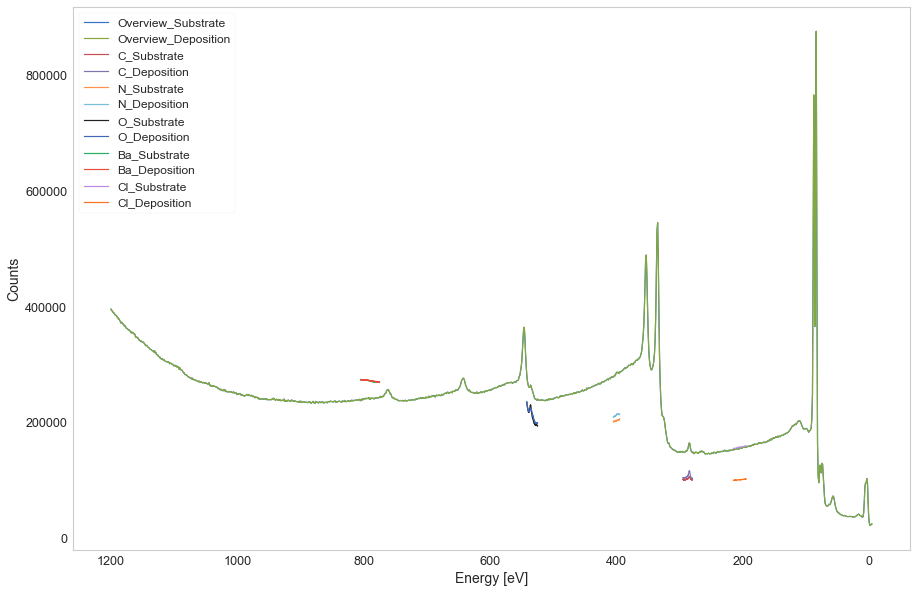

In [146]:
fig, ax = plt.subplots(1)
elem = ['Overview', 'C', 'N', 'O', 'Ba', 'Cl']
data_sg = [df_fbi, Csg, Nsg, Osg, Ba_sg, Cl_sg]
data_bg = [df_fbi, Cbg, Nbg, Obg, Ba_bg, Cl_bg]
for i, (d_sg, d_bg) in enumerate(zip(data_sg, data_bg)):
    plot_xps_element_spectra(d_bg, d_sg, ax, lb=elem[i])
#     ax.set_title(elem[i], fontsize=16)

ax.invert_xaxis()
    
plt.gcf().set_figheight(10)
plt.gcf().set_figwidth(15)

# Background subtraction (draft)

In [334]:
x = df_clean.C_1s.dropna().energy
y = df_clean.C_1s.dropna().counts
df_clean.C_1s.dropna()

properties,energy,counts
0,1191.61,40146.000
1,1191.71,40210.000
2,1191.81,40261.333
3,1191.91,40439.333
4,1192.01,40230.667
5,1192.11,40186.000
6,1192.21,40210.667
7,1192.31,40367.333
8,1192.41,40185.333
9,1192.51,40182.667


In [704]:
from scipy.ndimage.filters import gaussian_filter1d
y = gaussian_filter1d(y, sigma = 2)

def check_arrays(x, y):
    # Make sure we've been passed arrays and not lists.
    x = np.array(x)
    y = np.array(y)
    # Sanity check: Do we actually have data to process here?
    if not (x.any() and y.any()):
        print ("specs.shirley_calculate: One of the arrays x or y is empty. Returning zero background.")
        #return zeros(x.shape)

    # Next ensure the energy values are *decreasing* in the array,
    # if not, reverse them.
    if x[0] < x[-1]:
        is_reversed = True
        x = x[::-1]
        y = y[::-1]
        return x, y
    else:
        is_reversed = False

In [720]:
def find_integration_limits(x, y, flag_plot = False):
    # Locate the biggest peak.
    maxidx = abs(y - np.max(y)).argmin()

    # It's possible that maxidx will be 0 or -1. If that is the case,
    # we can't use this algorithm, we return a zero background.
    if maxidx == 0 or maxidx >= len(y) - 1:
        print ("specs.shirley_calculate: Boundaries too high for algorithm: returning a zero background.")
    #     return zeros(x.shape)

    # Locate the minima either side of maxidx.
    lmidx = abs(y[0:maxidx] - np.min(y[0:maxidx])).argmin()
    rmidx = abs(y[maxidx:] - np.min(y[maxidx:])).argmin() + maxidx


    xl = x[lmidx]
    yl = y[lmidx]
    xr = x[rmidx]
    yr = y[rmidx]

    if flag_plot:
        plt.plot(x, y, 'b-', label='C1s region')
        plt.axvline(x = x[maxidx], color='r', label='max position = %.2f' %x[maxidx])
        plt.axvline(x = xr, color='g', label='r_min position = %.2f' %xr)
        plt.axvline(x = xl, color='k', label='l_min position = %.2f' %xl)
        plt.xlabel('Energy (eV)')
        plt.ylabel('CPS')

        plt.legend()
    return xl, yl, xr, yr, lmidx, rmidx

In [717]:
def shirley_loop(x, y):
    # Initial value of the background shape B. The total background S = yr + B,
    # and B is equal to (yl - yr) below lmidx and initially zero above.
    
    xl, yl, xr, yr, lmidx, rmidx = find_integration_limits(x, y)
    
    B = np.zeros(x.shape)
    B[:lmidx] = yl - yr
    Bnew = B.copy()

    it = 0
    while it < maxit:
#         if DEBUG:
#             print ("Shirley iteration: %i" %it)
        
        # Calculate new k = (yl - yr) / (int_(xl)^(xr) J(x') - yr - B(x') dx')    
        ksum = np.trapz( + B[lmidx:rmidx - 1] + yr - y[lmidx:rmidx - 1] , x=x[lmidx:rmidx - 1])
        k = (yl - yr) / ksum
        
        # Calculate new B
        ysum = 0
        for i in range(lmidx, rmidx):
            ysum = np.trapz( B[i:rmidx - 1] + yr - y[i:rmidx - 1] , x=x[i:rmidx - 1])
            Bnew[i] = k * ysum

        # If Bnew is close to B, exit.
        if np.linalg.norm(Bnew-B) < tol:
            B = Bnew.copy()
            break
        else:
            B = Bnew.copy()
        it += 1

    if it >= maxit:
        print("specs.shirley_calculate: Max iterations exceeded before convergence.")
    if is_reversed:
        return ((yr + B)[::-1])
    else:
        return (yr + B)


(1206.61, 39934.22615876059, 1195.41, 40101.964298645435, 0, 112)

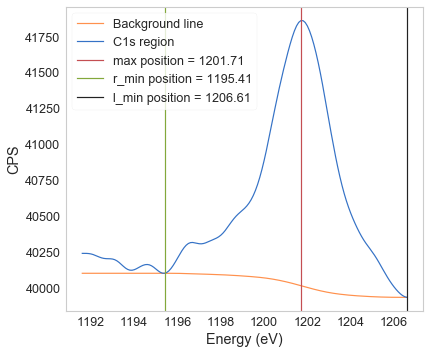

In [723]:
ybg = shirley_loop(x, y)
# plt.plot(x, y)
plt.plot(x, ybg, 'y', label='Background line')
find_integration_limits(x, y, flag_plot=True)